## Extracting GPS Coordinates and Coordinate Transform

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
%matplotlib inline

First we read the GPS position data. This consists of the latitude and longitude of the GPS satellites with respect to the Earth as well as the signal time of flight between the receiver and the Earth.

In [2]:
#extract data from file
GPS_data = np.loadtxt('gpsdata.txt', delimiter=' ')

#split data in lat and long and times
latitudes = GPS_data[:,0]
longitudes = GPS_data[:,1]
tof = GPS_data[:,2]

#put data into dataframe to check 
sat_info = pd.DataFrame(columns = ['Latitude','Longitude','Time'])
sat_info['Latitude'] = latitudes
sat_info['Longitude'] = longitudes
sat_info['Time'] = tof 

#check the data is ordered nicely. The Lat/Long values are rounded only in the table, nowehere else. 
sat_info

,Latitude,Longitude,Time
0,51.728899,16.118843,0.066837
1,29.926706,6.699826,0.068659
2,37.801000,-63.749680,0.072839
3,78.208865,-24.753475,0.068781


We first need to make a conversion from **Latitudinal and Longitudinal** coordinates to a **Cartesian (x, y, z)** coordinate system. 

This is straightforward, we just use the following equations:

$$x=R \cos{(Lat)} \cos{(Long)}$$
$$y=R \cos{(Lat)} \sin{(Long)}$$
$$z=R \sin{(Lat)}$$

We do make a number of assumptions with this data.
1. The satellites are all at the same orbit of 20200km 
2. The clocks on the satellites are all synchronised with each other 




In [3]:
def deg2cartesian(latitude,longitude):    
    """Converts lat and long coordinates to xyz cartesian
       coordinates"""    
    lat, long = np.deg2rad(latitude), np.deg2rad(longitude)
    R = (6371+20200) # radius of the earth+satellite orbit height
    x = R * np.cos(lat) * np.cos(long)
    y = R * np.cos(lat) * np.sin(long)
    z = R * np.sin(lat)
    return [x,y,z]

#get coordinates for each satellite
sat1 =deg2cartesian(latitudes[0],longitudes[0])
sat2 =deg2cartesian(latitudes[1],longitudes[1])
sat3 =deg2cartesian(latitudes[2],longitudes[2])
sat4 =deg2cartesian(latitudes[3],longitudes[3])

#calculate pseudorange from time of flight
pseudo1=(tof[0]*(299792458)/1000)
pseudo2=(tof[1]*(299792458)/1000)
pseudo3=(tof[2]*(299792458)/1000)
pseudo4=(tof[3]*(299792458)/1000)

#combine position and range data
gps1 = np.append(sat1, [pseudo1], 0)
gps2 = np.append(sat2, [pseudo2], 0)
gps3 = np.append(sat3, [pseudo3], 0)
gps4 = np.append(sat4, [pseudo4], 0)

#compile all satellite data into one list
total_gps = [gps1,gps2,gps3,gps4]

We now have cartesian coordinates for all 4 satellites with an origin centred at the Earth's core. The pseudorange is calculated by multiplying the time of flight beteen satellite and receiver by the speed of light.  

$$d=c\Delta t$$

In [4]:
#lets see what the xyz and d values look like for the 4 satellites
carts = pd.DataFrame([gps1,gps2,gps3,gps4])
carts= carts.rename({0: 'x', 1: 'y', 2: 'z', 3:r'$c\Delta t$'}, axis=1)
carts

,x,y,z,$c\Delta t$
0,15810.645043,4569.141532,20860.596587,20037.344479
1,22870.878266,2686.640297,13256.052665,20583.557345
2,9285.922985,-18829.723668,16285.919744,21836.509437
3,4930.752868,-2273.470791,26010.325790,20620.102058


## Newton's Method

We need to solve the following system of linear equations: 

$$f_k(x,y,z,b)=(x-x_k)^2+(y-y_k)^2+(z-z_k)^2 - (d_k-b)^2=0, \text{ } k=0,1,2,3,4$$

where k represents the function corresponding to one of the GPS satellites. 

To solve this system of non-linear equations we will use Newton's method for finding the roots of real valued equations. 
This algorithm is defined as 

$$x_{n+1} = x_n - \frac{f(x_n)}{f'(x_n)}$$

For a multivariate version of the above equation we instead consider the vector $U_n=(x_n,y_n,z_n,b_n)$. Newton's method now becomes

$$U_{n+1}=U_{n}- J^{-1}(U_n)F(U_n)$$

Where $U_0$ is the intital guess vector. $J(U_n)$ is the $4\times4$ Jacobian matrix of the function. $F(U_N)$ is a vector with the functions for each vector.


In [5]:
def func(x,y,z,b,coords): #coords is teh (x,y,z,d) for a given satellite
    """The GPS position equation. The coords input is the xyz
       position for a given satellite"""
    return (x-coords[0])**2+(y-coords[1])**2+(z-coords[2])**2-(coords[3]-b)**2

def grad_func(x,y,z,b,coords): 
    """Returns the gradient of the GPS function for the Jacobian"""
    return np.array([2*(x-coords[0]), 2*(y-coords[1]),2*(z-coords[2]),2*(coords[3]-b)])
    
def function_vector(x,y,z,b): 
    """Creates a vector containing the four GPS functions"""
    func_array=np.zeros([4,1])
    for i in range(4):
        func_array[i] =func(x,y,z,b,total_gps[i])
    return func_array    
 
def jacobian(x,y,z,b):   
    """Combines the calculated gradients to build the Jacobian of the function"""
    jac_array=np.zeros([4,4])
    for i in range(4):
        jac_array[i] = grad_func(x,y,z,b,total_gps[i])
    return jac_array


In [6]:
def newton(vector): 
    """Runs the Newton method for a single iteration"""
    jac = jacobian(*vector[0])
    inv_jac = np.linalg.inv(jac)
    vec = function_vector(*vector[0]) 
    x = np.matmul(inv_jac, vec)
    return (vector.T - x).T   

#we will run this function in a loop for a given number of iterations

We define a number of iterations over which Newton's algorithim will be run. 30 is chosen but given the well documented quick convergence of Newton's method it will probably take much less than this.

In [7]:
#define a (maximum) number of iterations for computation
iterations = 30

#set up empty lists to fil with our computed values
x=[0]*iterations
y=[0]*iterations
z=[0]*iterations
b=[0]*iterations

#define the inital values for x,y,z,b
#these are our initial guesses 
X = np.array([[0,0,0,0]])
counts=0
for i in range(iterations):
    counts+=1
    x[i] = X[0][0]
    y[i] = X[0][1]
    z[i] = X[0][2]
    b[i] = X[0][3]
    X = newton(X)

    if i >= 1: 
        if abs(x[i]-x[i-1]) <= 0.000000001:
            print("Convergence after %s iterations" %counts)
            break
    results = np.array([x[i],y[i],z[i],b[i]])

Convergence after 6 iterations


The results of Newton's method converge rapidly after only 6 iterations. The process returns a set of cartesian coordinates as well as the uncertainty in the pseudorange which contains the offset of the receiver clock. 

In [8]:
#lets check our results
results

array([3787.44791046, -413.9963335 , 5106.24183684, -397.64086142])

Now we just need to convert back into spherical coordinates

In [9]:
def spherical2cart(x,y,z):
    """Convert from Cartesian to Spherical Coordinates"""
    r = np.sqrt(x**2+y**2+z**2)
    theta_rad = np.arctan2(y,x)
    phi_rad = np.arcsin(z/r)
    return (r-6371), np.rad2deg(phi_rad), np.rad2deg(theta_rad)


rad, new_lat, new_long = spherical2cart(results[0],results[1],results[2])


print(r"Elevation: %s m" %round(rad*1000,4))
print(r"Latitude: %s degrees" %round(new_lat,4))
print(r"Longitude: %s degrees" %round(new_long,4))
print(r"Receiver Clock Offset: %s microseconds" %round((1e6)*results[3]/(3e5),4))

Elevation: 17.2135 m
Latitude: 53.2716 degrees
Longitude: -6.2381 degrees
Receiver Clock Offset: -1325.4695 microseconds


By using Newton's method we have found a set of coordinates corresponding to the receiver as well as the offset of the receiver clock. We have demonstrated how a system of 4 satellites can be used to perform trilateration and to identify the position of a GPS receiver with associated clock error. 

## Plotting Receiver Position on a Map

Given that Dublin sits around $53 ^{\circ}$N and $6 ^{\circ}$W and we know the GPS receiver is somewhere in Ireland, these values for Latitude and Longitude look promising. To check we can plot the position on a map of the country. 

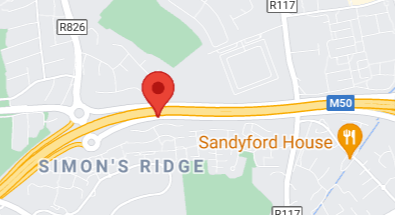

The results were first put into Google Maps to verify where in Ireland they lie. It turns out they correspond to an area along the M50 in South Dublin. 

The map of Dublin city plotted below shows the GPS point marked as a blue dot in the bottom right of the map 

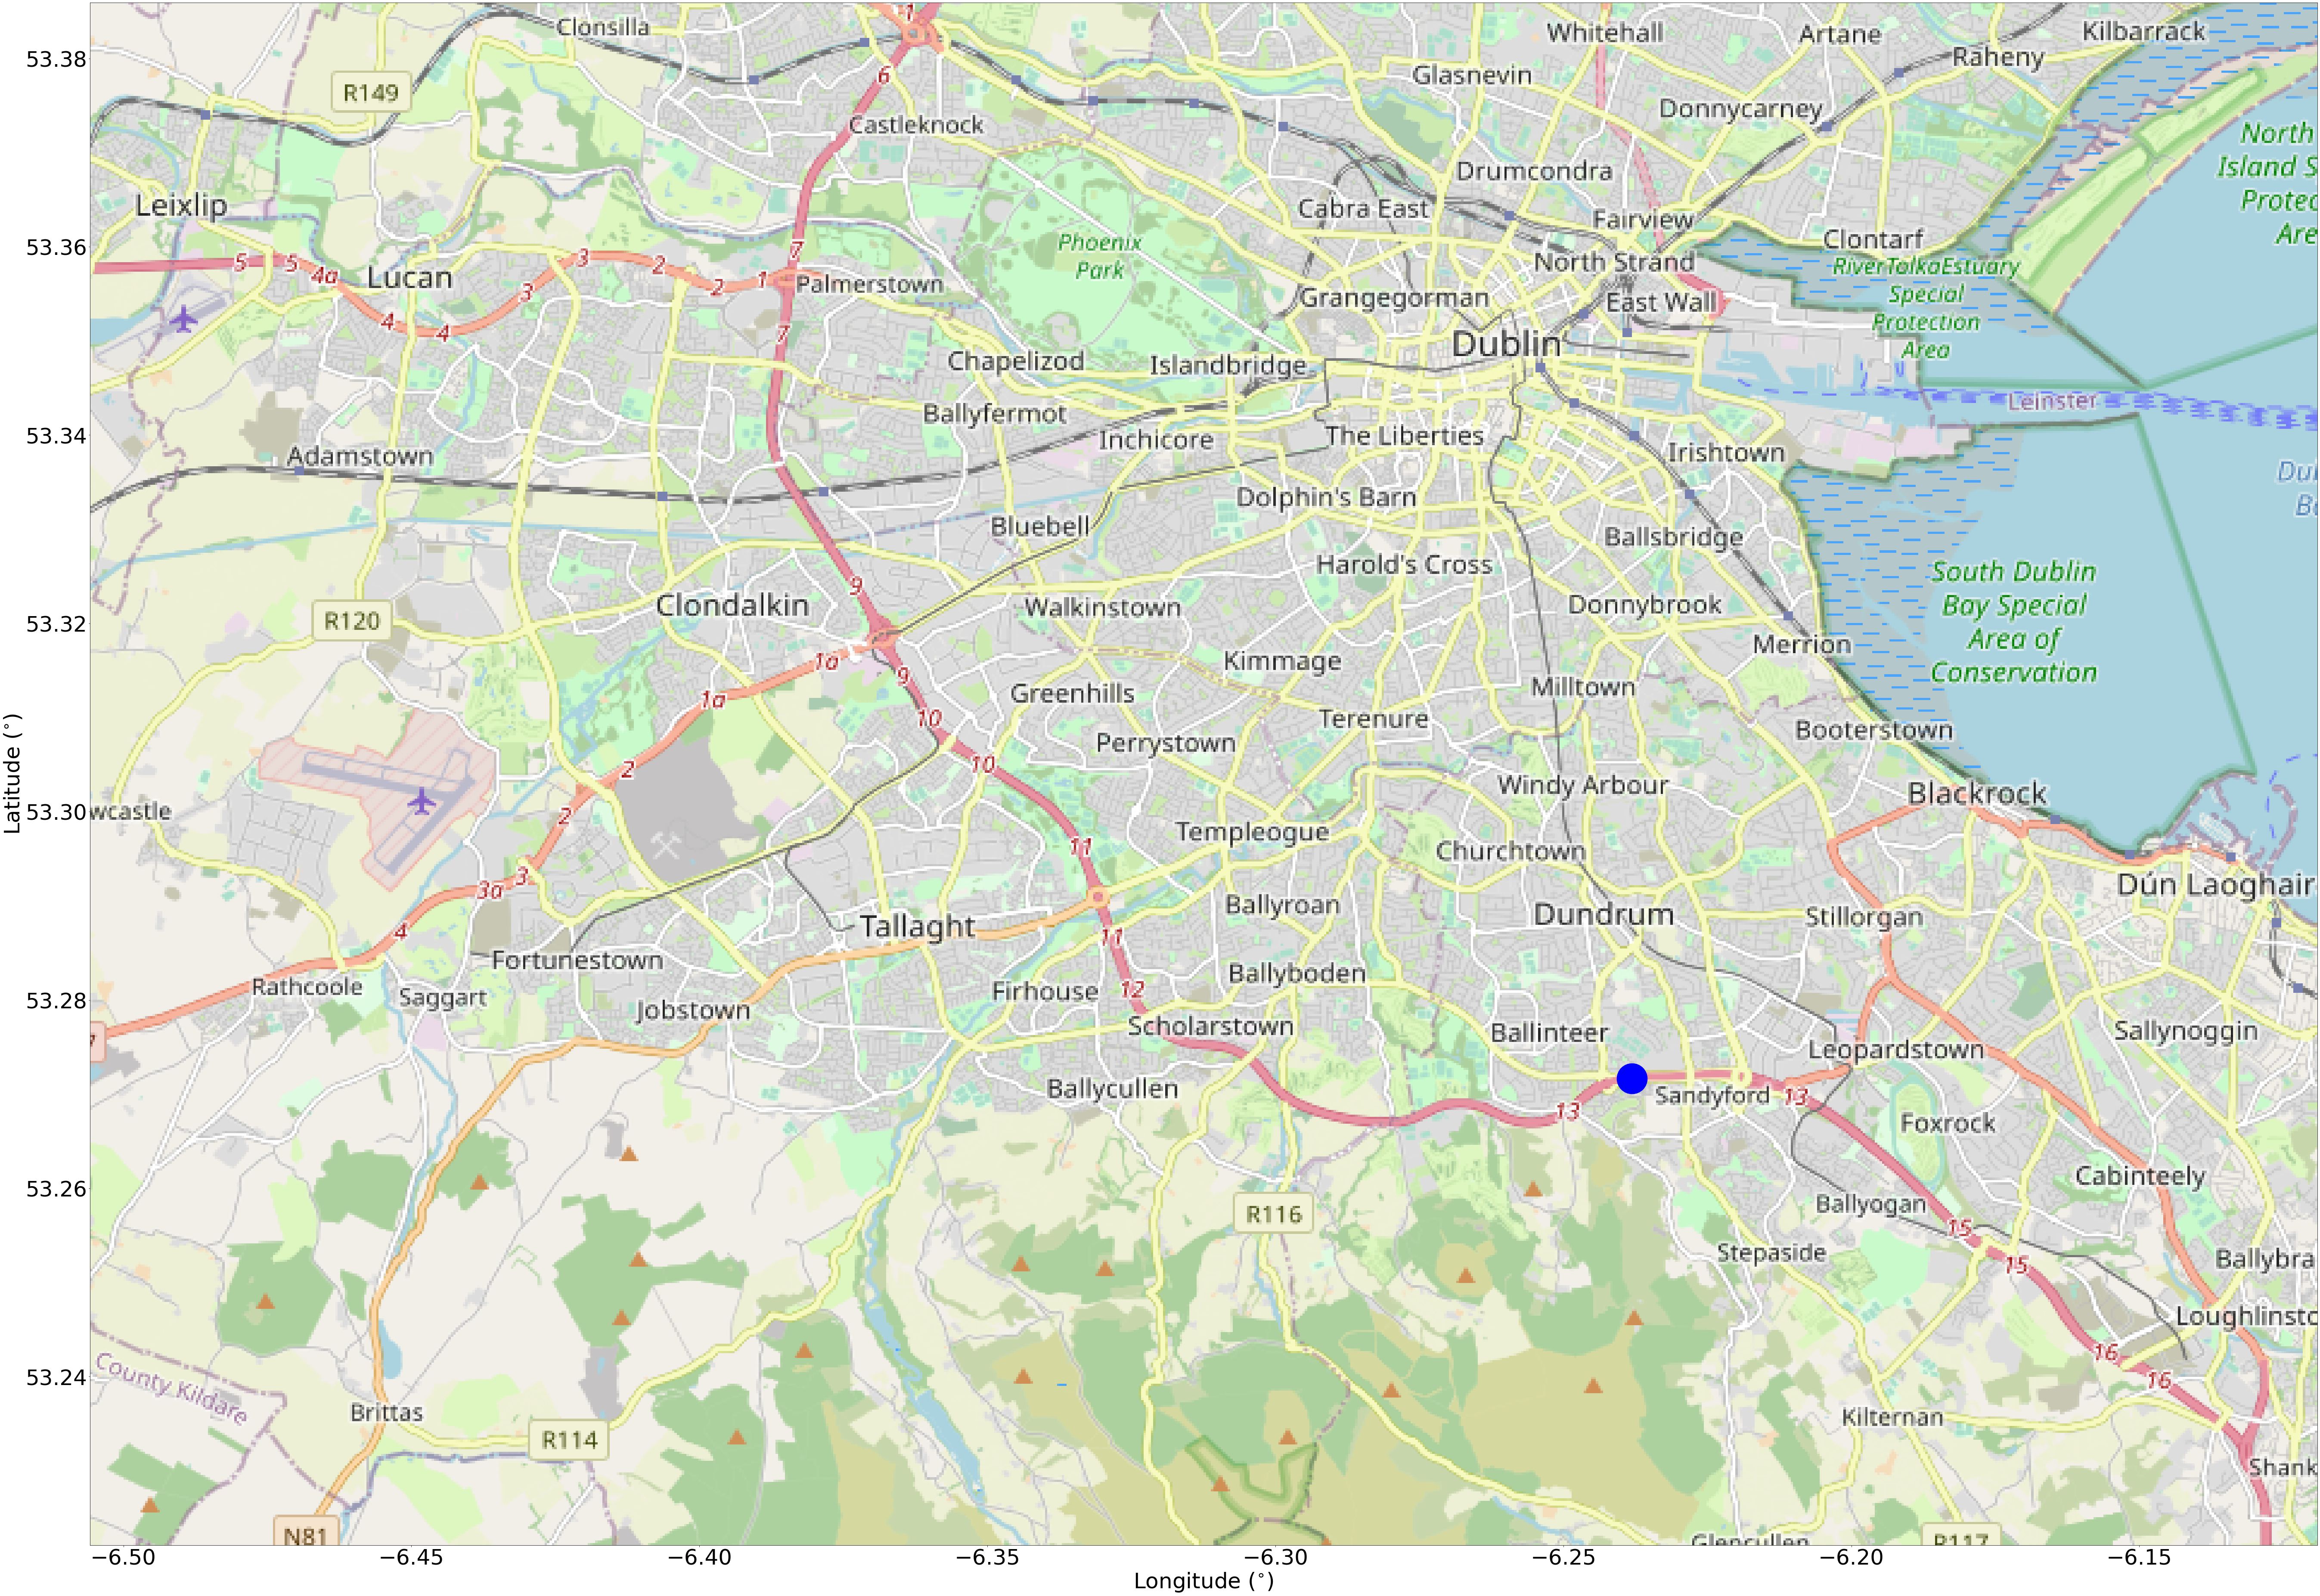

In [10]:
im = plt.imread('dublinmap.png')
plt.rcParams.update({'font.size': 50})
fig,ax=plt.subplots(1, figsize = (92.7,65.9))
ax.imshow(im, extent = [-6.5058,-6.1191, 53.2221, 53.3859], aspect='auto')
ax.set_xlabel(r"Longitude ($^{\circ}$)")
ax.set_ylabel(r"Latitude ($^{\circ}$)")
ax.scatter(new_long, new_lat, c='b', s=5000)

fig.savefig('map.png')

## Effect of Initial Guess on Convergence Rate 

In our first calculation, we gave our calculation no initial guess parameters. All variables were set to zero and input into the process. To check whether more accurate guess parameters lead to quicker rates of convergence we will run the test again with guess parameters based off the actual known location. 

In [11]:
#again we define our iterations
iterations = 30

#set up a list of 100 guess entries ranging from 0 up to the known values
guessX = np.array([np.linspace(0,3787.44791046,100),
                     np.linspace(0,-413.9963335,100),
                     np.linspace(0,5106.24183684,100),
                     np.linspace(0,-397.64086142,100)])

guess_list = [np.array([[guessX[0][i],guessX[1][i],guessX[2][i],guessX[3][i]]])
              for i in range(len(guessX[0]))]

We now have a list of guess parameters that we can cycle through to check how convergence varies with input. The code is exactly the same as the above procedure with an additional loop to iterate through the guesses. 

In [12]:
iterations=30

convergence_counts = []
for i in range(len(guess_list)):
    
    #set up empty lists 
    x=[0]*iterations
    y=[0]*iterations
    z=[0]*iterations
    b=[0]*iterations
    
    guesses = guess_list[i]
    #these are our initial guesses 
    
    counts=0
    for j in range(iterations):
        counts+=1
        x[j] = guesses[0][0]
        y[j] = guesses[0][1]
        z[j] = guesses[0][2]
        b[j] = guesses[0][3]
        guesses = newton(guesses)
    
        if j >= 1: 
            if abs(x[j]-x[j-1]) <= 0.00000001:
                convergence_counts.append(counts)
                break

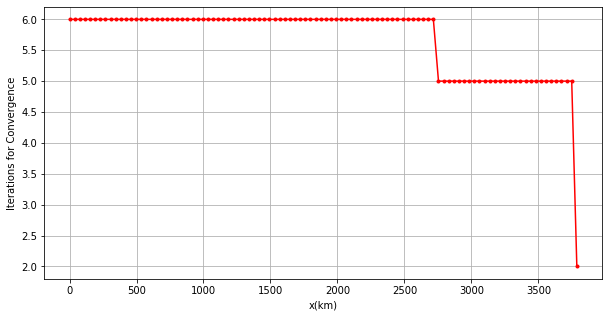

In [17]:
fig, ax = plt.subplots(1,figsize =(10,5))
plt.rcParams.update({'font.size': 10})
ax.plot(guessX[0], convergence_counts, 'r.-')
ax.set_xlabel(r'x(km)')
ax.set_ylabel(r'Iterations for Convergence')
ax.grid(True)

It seems that even by giving the algorithim nearly the exact answer we only shave off 1 iteration from the overall process. Therefore clearly even though Newton's method is very quick in general, there is not really much variation in this convergence rate. This is good news for satellites as it means that they do not depend on being in a particular area to determine the receiver position. 

As long as the receiever can view 4 satellites we can get a good estimation of coordinates and elevation. 

Obviously there are a number of assumptions we made which are highlighted above such as orbit height for the different satellite but as long as these are parameters that can be included in the preliminary trilateration equations.